# Variational Autoencoder for Handwritten Digit 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

## The MNIST dataset

### Get the data
MNIST dataset is provided by Keras directly. The following codes show how to load it. 

In [2]:
# the data, shuffled and split between train and test sets
(X_train_pre, y_train_pre), (X_test_pre, y_test_pre) = mnist.load_data()

In [4]:
img_rows, img_cols = 28, 28
X_train = X_train_pre.reshape(X_train_pre.shape[0], img_rows*img_cols) 
X_test = X_test_pre.reshape(X_test_pre.shape[0], img_rows*img_cols) 
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train /= 255. 
X_test /= 255.

print('training data shape:', X_train.shape)
print('{} train samples, {} test samples'.format(X_train.shape[0], X_test.shape[0]))

training data shape: (60000, 784)
60000 train samples, 10000 test samples


## The model

### Build the model

In [7]:
# network parameters
kernel_size = 3
filters = 32
intermediate_dim = 512

latent_dim = 2

# build encoder model
inputs = layers.Input(shape=img_cols*img_rows, name='encoder_input')
x = inputs

# generate latent vector Q(z|X)
x = layers.Dense(intermediate_dim, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

In [8]:
# use reparameterization trick to push the sampling out as input instead of sampling from Q(z|X)

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
       sample eps = N(0,I), then z = mean + sqrt(var)*eps
       
    Arguments:
        args:       mean and log of variance of Q(z|X)

    Returns:
        z (tensor): sampled latent vector
    """
    mean, log_var = args
    batch = K.shape(mean)[0]
    dim = K.int_shape(mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    
    return mean + K.exp(0.5 * log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [9]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
____________________________________________________________________________________________

In [10]:
# build decoder model
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(img_rows*img_cols, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [11]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= img_rows*img_cols
kl_loss =  -0.5 *K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

optimizer = keras.optimizers.RMSprop(0.0005, decay=1e-6)
vae.compile(optimizer=optimizer)

In [12]:
BATCH = 100
EPOCHS = 40

vae.fit(X_train,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, None))

Epoch 1/40
600/600 [==============================] - 10s 16ms/step - loss: 197.5075 - val_loss: 177.4783
Epoch 2/40
600/600 [==============================] - 10s 17ms/step - loss: 173.3868 - val_loss: 170.4872
Epoch 3/40
600/600 [==============================] - 10s 16ms/step - loss: 168.3848 - val_loss: 166.9850
Epoch 4/40
600/600 [==============================] - 8s 14ms/step - loss: 165.7026 - val_loss: 164.7819
Epoch 5/40
600/600 [==============================] - 8s 13ms/step - loss: 163.8694 - val_loss: 163.6154
Epoch 6/40
600/600 [==============================] - 8s 14ms/step - loss: 162.3937 - val_loss: 161.8229
Epoch 7/40
600/600 [==============================] - 8s 14ms/step - loss: 161.1002 - val_loss: 160.7442
Epoch 8/40
600/600 [==============================] - 8s 14ms/step - loss: 159.9922 - val_loss: 160.0235
Epoch 9/40
600/600 [==============================] - 8s 14ms/step - loss: 159.0724 - val_loss: 158.8222
Epoch 10/40
600/600 [==============================]

In [13]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 20x20 2D manifold of digits
    n = 20
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-10, 10, n)
    grid_y = np.linspace(-10, 10, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

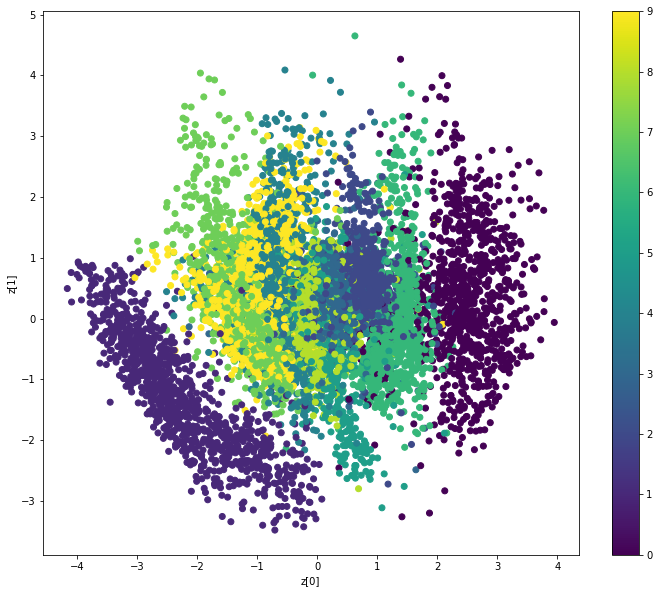

ValueError: The number of FixedLocator locations (21), usually from a call to set_ticks, does not match the number of ticklabels (20).

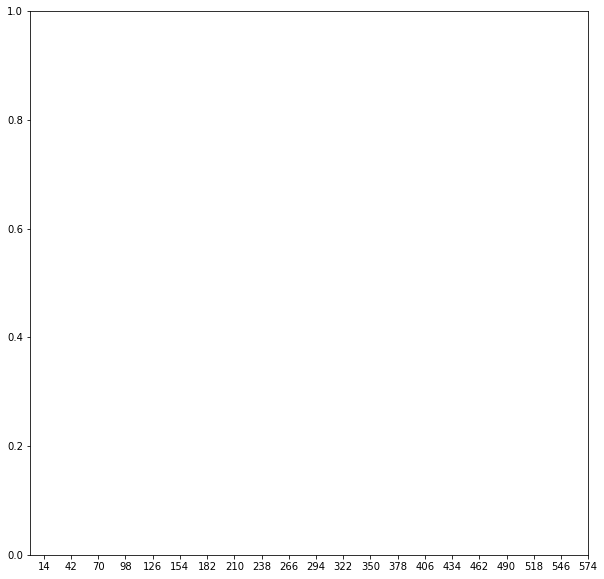

In [14]:
models = (encoder, decoder)
data = (X_test, y_test_pre)
plot_results(models, data, batch_size=BATCH, model_name="vae_cnn")

In [19]:
# network parameters
kernel_size = 3
filters = 32
intermediate_dim1 = 1024
intermediate_dim2 = 128
latent_dim = 10

# build encoder model
inputs = layers.Input(shape=img_cols*img_rows, name='encoder_input')
x = inputs

# generate latent vector Q(z|X)
x = layers.Dense(intermediate_dim1, activation='relu')(x)
x = layers.Dense(intermediate_dim2, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1024)         803840      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          131200      dense_9[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 10)           1290        dense_10[0][0]                   
____________________________________________________________________________________________

In [20]:
# build decoder model
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim2, activation='relu')(latent_inputs)
x = layers.Dense(intermediate_dim1, activation='relu')(x)
outputs = layers.Dense(img_rows*img_cols, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 10)]              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              132096    
_________________________________________________________________
dense_13 (Dense)             (None, 784)               803600    
Total params: 937,104
Trainable params: 937,104
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [21]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= img_rows*img_cols
kl_loss =  -0.5 *K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

optimizer = keras.optimizers.RMSprop(0.0005, decay=1e-6)
vae.compile(optimizer=optimizer)

In [18]:
BATCH = 100
EPOCHS = 40

vae.fit(X_train,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, None))

Epoch 1/40
600/600 [==============================] - 18s 30ms/step - loss: 159.8467 - val_loss: 132.6530
Epoch 2/40
600/600 [==============================] - 17s 29ms/step - loss: 127.1568 - val_loss: 121.3069
Epoch 3/40
600/600 [==============================] - 17s 28ms/step - loss: 119.3484 - val_loss: 116.0920
Epoch 4/40
600/600 [==============================] - 17s 28ms/step - loss: 115.3413 - val_loss: 112.3398
Epoch 5/40
600/600 [==============================] - 17s 28ms/step - loss: 112.8239 - val_loss: 111.7178
Epoch 6/40
600/600 [==============================] - 17s 29ms/step - loss: 111.0533 - val_loss: 109.8014
Epoch 7/40
600/600 [==============================] - 17s 28ms/step - loss: 109.6161 - val_loss: 109.1115
Epoch 8/40
600/600 [==============================] - 16s 27ms/step - loss: 108.5457 - val_loss: 108.0660
Epoch 9/40
600/600 [==============================] - 17s 28ms/step - loss: 107.5948 - val_loss: 106.5532
Epoch 10/40
600/600 [=========================

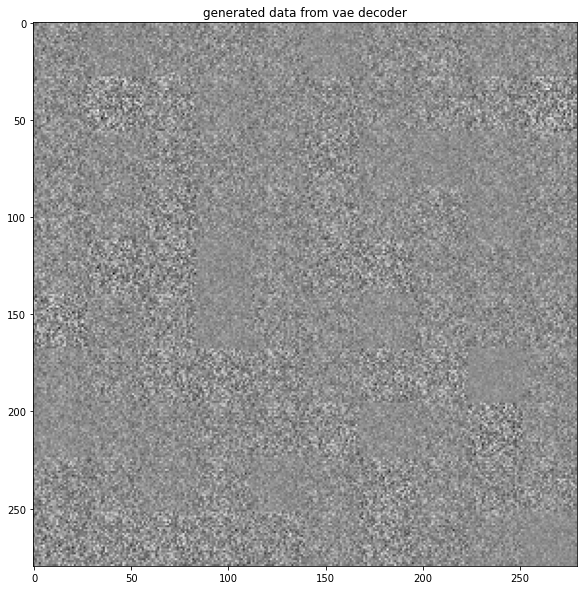

In [22]:
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
z_samples = np.random.randn(n*n, latent_dim)
x_decoded = decoder.predict(z_samples)

for i in range(n):
    for j in range(n):
        digit = x_decoded[i*n+j, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title("generated data from vae decoder")
plt.imshow(figure, cmap='Greys_r')
plt.show()

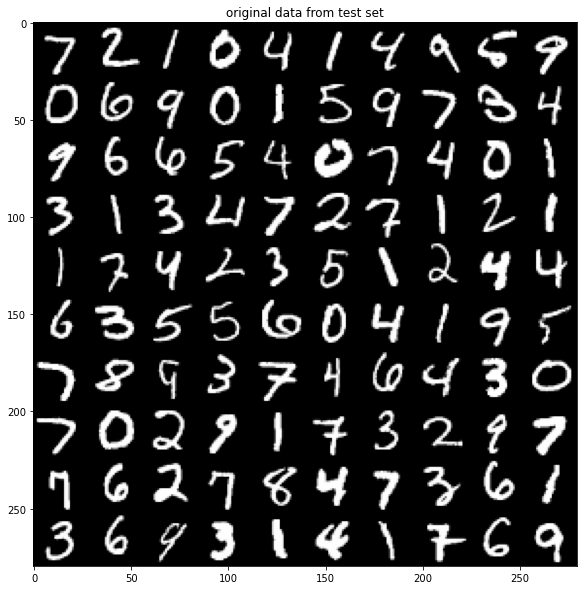

In [23]:
# compared to the original dataset
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
    for j in range(n):
        digit = X_test[i*n+j, :].reshape([digit_size, digit_size])
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title("original data from test set")
plt.imshow(figure, cmap='Greys_r')
plt.show()